[![Troy Tompkins](https://github.com/ttompk/musings/blob/master/images/t-dist.png?raw=true "Troy's Github")](https://github.com/ttompk/als) ![Troy](https://github.com/ttompk/musings/blob/master/images/name.png?raw=true)

# Fastai Template for Single Label CNN
---

[Today's Date]  
Written in python: 3.6.8

In [1]:
from platform import python_version
print('Your python version: {}'.format(python_version()))

Your python version: 3.6.8


## Notebook TOC
---
1. Overview
2. Libraries
3. Generalized Functions
4. Data ETL
5. Analysis
6. Conclussion
7. Next Steps

## 1. Overview
---
This notebook was developed for image detection using the Fastai library.

### Directive/Objective
The instructions were provided in ...  

**Part 1**  
This

**Part 2**  
That


### Data Source
The orginal data consisted of ...   



## 2. Libraries
---

In [1]:
# basic kit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
import pandas_profiling
import re
import collections

In [2]:
from fastai.vision import *


In [3]:
%load_ext autoreload
%autoreload 2

## 3. Generalized Functions
---

## 4. Data
---

In [105]:
# Dataset is the MNIST digital number images
path = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False)
path.ls()      # shows what's in the folder

[PosixPath('/Users/shared/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/Users/shared/.fastai/data/mnist_tiny/models'),
 PosixPath('/Users/shared/.fastai/data/mnist_tiny/test'),
 PosixPath('/Users/shared/.fastai/data/mnist_tiny/train'),
 PosixPath('/Users/shared/.fastai/data/mnist_tiny/valid')]

In [109]:
path_train = path/'train'
path_train.ls()

[PosixPath('/Users/shared/.fastai/data/mnist_tiny/train/3'),
 PosixPath('/Users/shared/.fastai/data/mnist_tiny/train/7')]

In [107]:
data = (ImageList.from_folder(path)   # where to find the data?
        .split_by_folder()             # How to split in train/valid? -> use the folders
        .label_from_folder()           # How to label? -> depending on the folder of the filenames
        #.add_test_folder()            # Optionally add a test set (here default name is test)
        .transform(tfms, size=32)      # Data augmentation? -> use tfms with a size of 64
        .databunch()                   # Finally? -> use the defaults for conversion to ImageDataBunch
        .normalize(imagenet_stats))    # normalizes 'x' with 'mean' and 'std' (fastai variable 'imagenet_stats' holds these values for train and val - i believe)

In [106]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

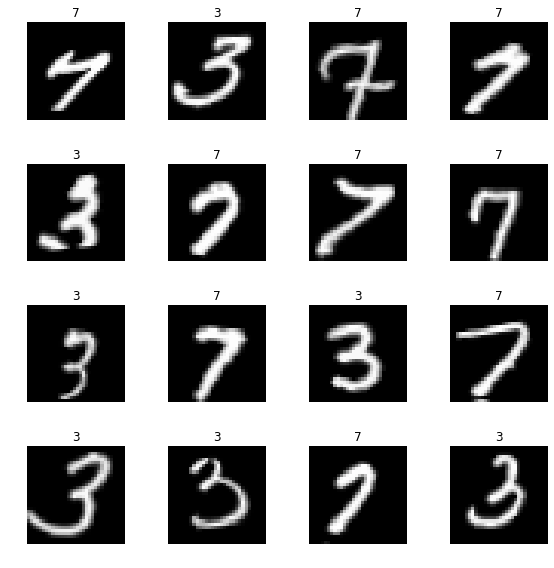

In [45]:
# display images
data.show_batch(rows=4, figsize=(8,8))

LabelList (709 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
3,3,3,3,3
Path: /Users/shared/.fastai/data/mnist_tiny

## 5. Training
---

#### **5.1. Model**

In [46]:
# simple CNN
#model = simple_cnn((3,16,16,2))
model = models.resnet18

#### **5.2. Learner**

Trainer for *model* using *data* to minimize *loss_func* with optimizer *opt_func*.

`Learner(data:DataBunch, model:Module, opt_func:Callable='Adam', loss_func:Callable=None, metrics:Collection[Callable]=None, true_wd:bool=True, bn_wd:bool=True, wd:Floats=0.01, train_bn:bool=True, path:str=None, model_dir:PathOrStr='models', callback_fns:Collection[Callable]=None, callbacks:Collection[Callback]=<factory>, layer_groups:ModuleList=None, add_time:bool=True, silent:bool=None, cb_fns_registered:bool=False)`

In [138]:
#learn = Learner(data, model)
learn = cnn_learner(data, model, callback_fns=ShowGraph) # `callback_fns=ShowGraph` is opotional
#learn = unet_learner(data, model)

# summary of learner
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 16, 16]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 16, 16]         128        True      
______________________________________________________________________
ReLU                 [64, 16, 16]         0          False     
______________________________________________________________________
MaxPool2d            [64, 8, 8]           0          False     
______________________________________________________________________
Conv2d               [64, 8, 8]           36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 8, 8]           128        True      
______________________________________________________________________
ReLU                 [64, 8, 8]           0          False     
___________________________________________________

#### 5.2.1. Learning Rate Finder

`lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None)`

In [145]:
# run learning rate finder
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


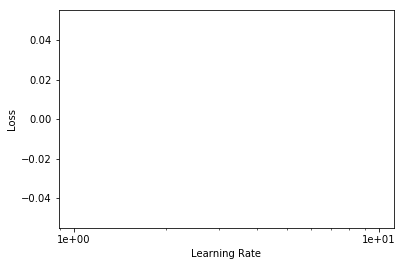

In [144]:
# plot the learning rate and losses -> plots the lr_find results
learn.recorder.plot()

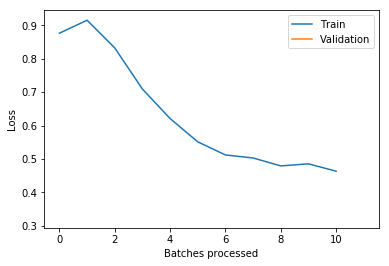

In [142]:
# plot losses. Note: validation losses are only calculated once per epoch, whereas training losses are calculated after every batch.
learn.recorder.plot_losses()

In [ ]:
# plot the learning rate and momentum 
learn.recorder.plot_lr(show_moms=True)

#### 5.2.2 Learn parameters

In [80]:
print("Classes: {}".format(learn.data.classes))
print("Batch size: {}".format(learn.data.batch_size))
print("N in training set: {}".format(len(learn.data.train_ds)))
print("N in validation set: {}".format(len(learn.data.valid_ds)))

Classes: ['3', '7']
Batch size: 64
N in training set: 709
N in validation set: 699


#### **3. Metrics**

Link to [fastai metrics](https://docs.fast.ai/metrics.html) documentation.

In [84]:
# Metrics
# metrics always calculated on the validation set
learn.metrics=[accuracy]
print("Metrics in use: {}".format(learn.metrics))

Metrics in use: [<function accuracy at 0x1a1f925158>]


#### **4. Callbacks**

In [51]:
# Callbacks to modify training
#cb = OneCycleScheduler(learn, lr_max=0.01)   # this funciton not working

#### **5. Fit**

In [139]:
n_epochs = 1
#learn.fit(n_epochs, callbacks=cb)
learn.fit_one_cycle(n_epochs,1e-2)

epoch,train_loss,valid_loss,time
0,0.463207,0.323324,01:04


#### **6. Save / Load Learner**

Only the parameters are saved, not the actual architecture (so you'll need to create your model in the same way before loading weights back in). Models are saved to the `path/model_dir` directory.

In [ ]:
# saves and loads models from the path - only the parameters are saved, not the architecture
learn.save('mini_train')
#learn.load('mini_train')

## 6. Predictions
---

#### 6.1. Class Predictions

**predict**(item:ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs)

In [61]:
learn.data.classes

['3', '7']

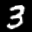

In [111]:
test = learn.data.train_ds[0][0]   # grab one example from training set
test

In [121]:
learn.data.train_ds

LabelList (709 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
3,3,3,3,3
Path: /Users/shared/.fastai/data/mnist_tiny

In [59]:
pred = learn.predict(test)  #make prediction
pred

(Category 3, tensor(0), tensor([1.0000e+00, 3.7344e-06]))

In [67]:
# predicted class label
print("Predicted label: {}".format(learn.data.classes[pred[1]]))

Predicted label: 3


In [66]:
# predicted class label - proof
# tensor(0) = learn.data.classes[0]
print("Predicted label: {}".format(learn.data.classes[0]))

Predicted label: 3


#### 6.2. Prediciton Probabilities

**get_preds**(ds_type:DatasetType=<DatasetType.Valid: 2>, activ:Module=None, with_loss:bool=False, n_batch:Optional[int]=None, pbar:Union[MasterBar, ProgressBar, NoneType]=None)

- *'with_loss'* returns loss on each prediction

In [71]:
# get predictions from batch size
# note: the predictions default to the validation set
preds = learn.get_preds()
preds

[tensor([[9.9999e-01, 7.3564e-06],
         [9.9998e-01, 1.9055e-05],
         [9.9991e-01, 8.5667e-05],
         ...,
         [1.3300e-04, 9.9987e-01],
         [2.5505e-04, 9.9974e-01],
         [8.7703e-03, 9.9123e-01]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [73]:
# first element of tuple returns all predictions for each class
preds[0]

tensor([[9.9999e-01, 7.3564e-06],
        [9.9998e-01, 1.9055e-05],
        [9.9991e-01, 8.5667e-05],
        ...,
        [1.3300e-04, 9.9987e-01],
        [2.5505e-04, 9.9974e-01],
        [8.7703e-03, 9.9123e-01]])

In [75]:
# second element of tuple returns all target labels
preds[1][0:10]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [77]:
# note: the predictions default to the validation set
len(learn.data.valid_ds)

699

In [81]:
len(preds[0])

699

In [82]:
# note: predictions from the training set
learn.get_preds(ds_type=DatasetType.Train)

[tensor([[4.1900e-02, 9.5810e-01],
         [7.5309e-05, 9.9992e-01],
         [1.2761e-03, 9.9872e-01],
         ...,
         [8.8204e-04, 9.9912e-01],
         [1.0000e+00, 4.5236e-07],
         [9.8593e-01, 1.4067e-02]]),
 tensor([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
         1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
         1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
         1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
         0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
         1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
         1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
         1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
         0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 

In [86]:
# get the losses for each sample (third tensor) from the training set
per_sample_losses = learn.get_preds(ds_type=DatasetType.Train, with_loss=True)[2]
per_sample_losses[0:10]   # first 10 samples shown

tensor([3.2234e-04, 4.7684e-07, 2.3754e-02, 6.4373e-05, 2.1863e-03, 9.5367e-07,
        8.5235e-04, 1.2541e-04, 5.4953e-03, -0.0000e+00])

#### Classification Interpretation

**interpret**(learn:Learner, ds_type:DatasetType=<DatasetType.Valid: 2>, tta=False)  

Create a `ClassificationInterpretation` object from `learner` on `ds_type` with tta.

In [134]:
# instantiate interpretation class
interp = ClassificationInterpretation.from_learner(learn)

In [137]:
# model summary
interp.model_summary()

AttributeError: 'ClassificationInterpretation' object has no attribute 'model_summary'

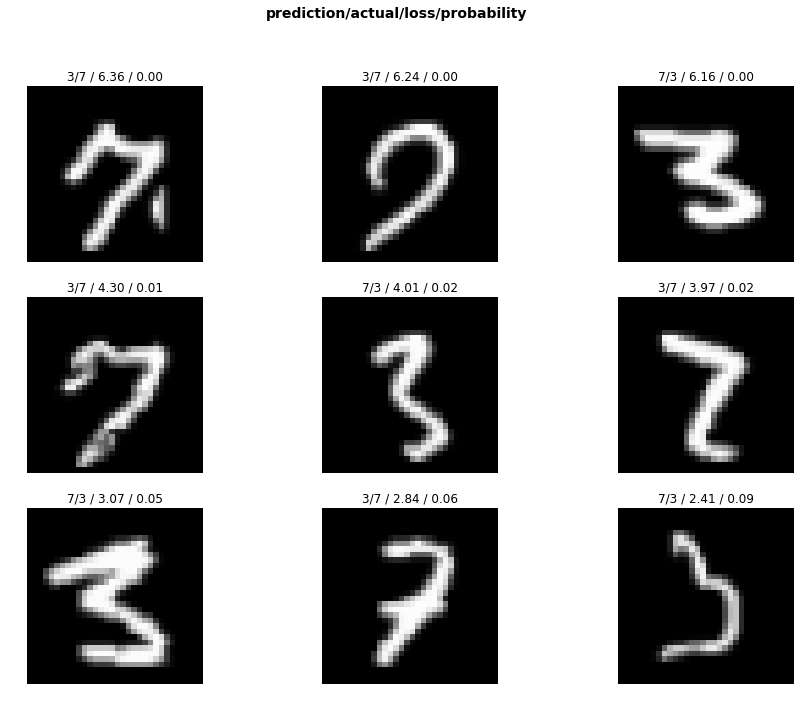

In [124]:
# plot top losses
interp.plot_top_losses(9, figsize=(15,11))

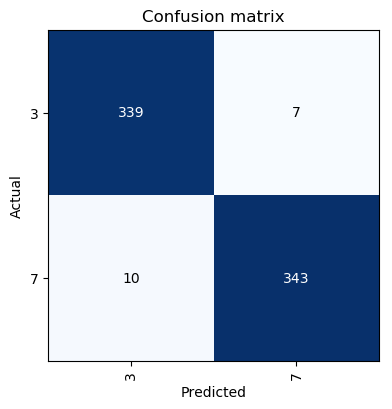

In [130]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=100)

In [131]:
interp.most_confused(min_val=2)
# actual , predicted, number wrong

[('7', '3', 10), ('3', '7', 7)]

AttributeError: 'Learner' object has no attribute 'model_summary'

#### 6.3. Model loss and metrics

**validate**(dl=None, callbacks=None, metrics=None)

Return the calculated loss and the metrics of the current model on the given data loader *'dl'*. The default data loader *'dl'* is the validation dataloader.

In [90]:
# model loss and metrics on validation set
model_val = learn.validate(learn.data.valid_dl)
model_val

[0.08149007, tensor(0.9757)]

In [91]:
# model loss on validation set
model_loss = model_val[0]
print("Model loss: {}".format(model_loss))

Model loss: 0.08149006962776184


In [92]:
# model accuracy on validation set
model_metrics = model_val[1]
print("Model {}: {}".format(learn.metrics, model_loss))

Model [<function accuracy at 0x1a1f925158>]: 0.08149006962776184


In [94]:
# model loss and metrics on training set
learn.validate(learn.data.train_dl)

[0.1674102, tensor(0.9489)]

#### 6.4 AUC

There is a class for AUROC in fastai but no plotting function. Use the roc_plot.py file to plot the training and validation curves.

In [ ]:
y_true = 
roc_plot(y_true, y_scores, title)

In [95]:
from sklearn.metrics import roc_curve, auc

def roc_curve(predictions):
    '''
    plots an roc curve
    ---
    Inputs:
        predictions:   a list of lists. Each nested list contains: [y_true, y_proba, title]
                y_true:     array. true binary labels for y. Positive label should = 1.
                y_proba:    array. Target scores, can either be probability estimates of the positive class, confidence values, 
                        or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).
                title:      str. name the plottrue labels, probabilities, name of data source]
    '''
    # intialize plotting
    plt.figure() 
    lw = 2 

    # plot each data source
    for d_source in [predictions]:
        y_true = d_source[0]
        y_scores = d_source[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)  # this not plotted here but could be a useful metric if needed
        plt.plot(fpr, tpr, lw=lw, label=d_source[2]) # color='darkorange',

    # contiue plotting remaining items
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title(title) 
    plt.legend(loc="lower right") 
    plt.show()

In [96]:
train_true = 
train_preds = learn.get_preds(ds_type=DatasetType.Train)[0]

tensor([[1.0000e+00, 2.1126e-06],
        [1.0000e+00, 4.9787e-07],
        [6.7191e-04, 9.9933e-01],
        ...,
        [9.9984e-01, 1.5916e-04],
        [9.9997e-01, 2.8409e-05],
        [3.1154e-04, 9.9969e-01]])

In [ ]:
predictions = [train_true, train_preds, ]
roc_curve(predictions)

#### 6.5. Show Results

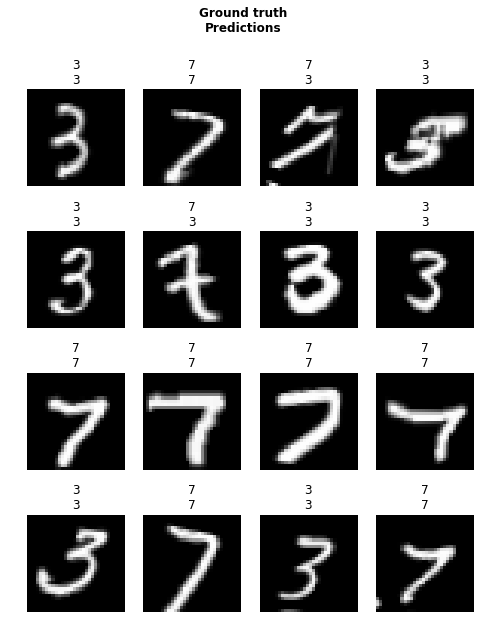

In [93]:
#learn.show_results()
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(8,10))

## Delpoying the Model

When you are ready to put your model in production, export the minimal state of your Learner with:

**export**( file:PathLikeOrBinaryStream='export.pkl', destroy=False)  

example: `learn.export('trained_model.pkl')`